In [1]:
import pandas as pd

train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')
anime_data = pd.read_csv('anime.csv')
profile_data = pd.read_csv('profile.csv')
train_data.head(), test_data.head(), anime_data.head(), profile_data.head()

(         user  anime_id                                               text  \
 0  cd931c240b      6574  \n           \n         \n           \n       ...   
 1  bf666ac921     12531  \n           \n         \n           \n       ...   
 2  24a73e9958     23079  \n           \n         \n           \n       ...   
 3  d45057b3ec      8769  \n           \n         \n           \n       ...   
 4  9b33e2839e     12367  \n           \n         \n           \n       ...   
 
    score  
 0      9  
 1      8  
 2      5  
 3      7  
 4      2  ,
          user  anime_id                ID
 0  df5ce90323      2191   df5ce90323/2191
 1  fd47680337     12355  fd47680337/12355
 2  8bfc6cea02      3287   8bfc6cea02/3287
 3  5ba4de2706      5114   5ba4de2706/5114
 4  6f78771003     33966  6f78771003/33966,
       id                             title  \
 0  28891           Haikyuu!! Second Season   
 1  23273           Shigatsu wa Kimi no Uso   
 2  34599                     Made in Abyss   
 3  

In [2]:
missing_values_train = train_data.isnull().sum()
missing_values_test = test_data.isnull().sum()
missing_values_anime = anime_data.isnull().sum()
missing_values_profile = profile_data.isnull().sum()
missing_values_train, missing_values_test, missing_values_anime, missing_values_profile

(user        0
 anime_id    0
 text        0
 score       0
 dtype: int64,
 user        0
 anime_id    0
 ID          0
 dtype: int64,
 id                0
 title             0
 synopsis        785
 genre             0
 episodes        543
 members           0
 popularity        0
 ranked         1757
 start_month     295
 start_day      1990
 start_year     1656
 end_month       766
 end_day        2404
 end_year       2114
 dtype: int64,
 user            0
 gender      17007
 birthday    21037
 dtype: int64)

In [3]:
# Filling missing values for anime.csv
anime_data['synopsis'].fillna('', inplace=True)
anime_data['episodes'].fillna(anime_data['episodes'].median(), inplace=True)

# ranked は start_year=2020 または genre に Hentai が含まれている場合は全体の平均値、それ以外は max + 1 で埋める
anime_data['ranked'].fillna(anime_data[anime_data['start_year'] == 2020]['ranked'].mean(), inplace=True)
anime_data['ranked'].fillna(anime_data[anime_data['genre'].str.contains('Hentai')]['ranked'].mean(), inplace=True)
anime_data['ranked'].fillna(anime_data['ranked'].max() + 1, inplace=True)

# Filling missing values for profile.csv
profile_data['gender'].fillna('Unknown', inplace=True)
anime_data.isnull().sum(), profile_data.isnull().sum()

(id                0
 title             0
 synopsis          0
 genre             0
 episodes          0
 members           0
 popularity        0
 ranked            0
 start_month     295
 start_day      1990
 start_year     1656
 end_month       766
 end_day        2404
 end_year       2114
 dtype: int64,
 user            0
 gender          0
 birthday    21037
 dtype: int64)

In [4]:
from datetime import datetime

# Converting birthday to age
def calculate_age(birthday):
    try:
        birth_date = datetime.strptime(birthday, '%b %d, %Y')
        return 2023 - birth_date.year
    except:
        return None

profile_data['age'] = profile_data['birthday'].apply(calculate_age)
profile_data.drop(columns=['birthday'], inplace=True)

# 欠損値の数を確認
profile_data.isnull().sum()

user          0
gender        0
age       26915
dtype: int64

In [5]:
# 30歳で埋める
profile_data['age'].fillna(30, inplace=True)

In [6]:
profile_data.head()

,user,gender,age
0,a6d7097412,Male,29.0
1,a5b892cad4,Female,23.0
2,033266b0aa,Unknown,30.0
3,6a18591ad5,Male,30.0
4,4fba2ad28f,Male,24.0


<Axes: >

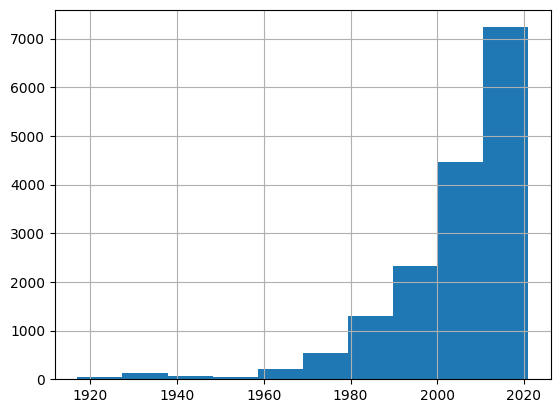

In [7]:
# start_yearが欠損値のデータのうち、start_monthが欠損値でないデータは start_year = start_month とする
anime_data.loc[anime_data['start_year'].isnull() & anime_data['start_month'].notnull(), 'start_year'] = anime_data['start_month']

# start_yearが欠損値のidを持っておく
missing_start_year_ids = anime_data.loc[anime_data['start_year'].isnull(), 'id']

# log(member / popularity) の値のカラムを作成
import math
anime_data['member_popularity'] = anime_data.apply(lambda x: 10 + math.log(x['members'] / x['popularity']), axis=1)

# log(member / popularity) の値でソートしたものを作成
anime_data_sorted = anime_data.sort_values('member_popularity', ascending=False)

# start_yearでソートしたものを作成
anime_data_sorted_by_start_year = anime_data.sort_values('start_year', ascending=False)

# start_yearの欠損値を、start_yearの大きさの順位が log(member / popularity) の値の順位の数字 と同じ値の start_year で埋める
i = 0
for row in anime_data_sorted.itertuples():
    if pd.isna(row.start_year):
        anime_data.loc[anime_data['id'] == row.id, 'start_year'] = anime_data_sorted_by_start_year.iloc[i]['start_year']
    i += 1

# start_yearの欠損値を1940で埋める
anime_data['start_year'].fillna(1940, inplace=True)

# start_yearの分布を確認
anime_data['start_year'].hist()

In [8]:
# titleに Ⅱ, Ⅲ, Ⅳが含まれる、または、titleに "Season" が含まれる、 2nd, 3rd, 4th が含まれる、または、titleの末尾に 2, 3, 4 が含まれるものは 1 にする
season_symbols = ['Ⅱ', 'Ⅲ', 'Ⅳ', 'II', 'III', 'IV', '2nd', '3rd', '4th', ' Season', ' season']
anime_data['season'] = anime_data['title'].apply(lambda x: 1 if any(s in x for s in season_symbols) or any(x.endswith(s) for s in ['2', '3', '4']) else 0)

anime_data.head()

,id,title,synopsis,genre,episodes,members,popularity,ranked,start_month,start_day,start_year,end_month,end_day,end_year,member_popularity,season
0,28891,Haikyuu!! Second Season,Following their participation at the Inter-Hig...,"['Comedy', 'Sports', 'Drama', 'School', 'Shoun...",25.0,489888,141,25.0,10.0,4.0,2015.0,3.0,27.0,2016.0,18.153172,1
1,23273,Shigatsu wa Kimi no Uso,Music accompanies the path of the human metron...,"['Drama', 'Music', 'Romance', 'School', 'Shoun...",22.0,995473,28,24.0,10.0,10.0,2014.0,3.0,20.0,2015.0,20.478769,0
2,34599,Made in Abyss,The Abyss—a gaping chasm stretching down into ...,"['Sci-Fi', 'Adventure', 'Mystery', 'Drama', 'F...",13.0,581663,98,23.0,7.0,7.0,2017.0,9.0,29.0,2017.0,18.688679,0
3,5114,Fullmetal Alchemist: Brotherhood,"""In order for something to be obtained, someth...","['Action', 'Military', 'Adventure', 'Comedy', ...",64.0,1615084,4,1.0,4.0,5.0,2009.0,7.0,4.0,2010.0,22.908603,0
4,31758,Kizumonogatari III: Reiketsu-hen,After helping revive the legendary vampire Kis...,"['Action', 'Mystery', 'Supernatural', 'Vampire']",1.0,214621,502,22.0,1.0,6.0,2017.0,1.0,6.0,2017.0,16.058029,1


In [9]:
# genreをone-hotエンコーディング genre_〇〇 にする
import ast
anime_data['genre'] = anime_data['genre'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

genres = set()
for row in anime_data.itertuples():
    if isinstance(row.genre, list):
        for genre in row.genre:
            genres.add(genre)

for genre in genres:
    anime_data['genre_' + genre] = anime_data['genre'].apply(lambda x: 1 if isinstance(x, list) and genre in x else 0)

anime_data.head()


,id,title,synopsis,genre,episodes,members,popularity,ranked,start_month,start_day,...,genre_Music,genre_Shoujo,genre_Comedy,genre_Yaoi,genre_Mystery,genre_Psychological,genre_Shounen,genre_Parody,genre_Martial Arts,genre_Yuri
0,28891,Haikyuu!! Second Season,Following their participation at the Inter-Hig...,"[Comedy, Sports, Drama, School, Shounen]",25.0,489888,141,25.0,10.0,4.0,...,0,0,1,0,0,0,1,0,0,0
1,23273,Shigatsu wa Kimi no Uso,Music accompanies the path of the human metron...,"[Drama, Music, Romance, School, Shounen]",22.0,995473,28,24.0,10.0,10.0,...,1,0,0,0,0,0,1,0,0,0
2,34599,Made in Abyss,The Abyss—a gaping chasm stretching down into ...,"[Sci-Fi, Adventure, Mystery, Drama, Fantasy]",13.0,581663,98,23.0,7.0,7.0,...,0,0,0,0,1,0,0,0,0,0
3,5114,Fullmetal Alchemist: Brotherhood,"""In order for something to be obtained, someth...","[Action, Military, Adventure, Comedy, Drama, M...",64.0,1615084,4,1.0,4.0,5.0,...,0,0,1,0,0,0,1,0,0,0
4,31758,Kizumonogatari III: Reiketsu-hen,After helping revive the legendary vampire Kis...,"[Action, Mystery, Supernatural, Vampire]",1.0,214621,502,22.0,1.0,6.0,...,0,0,0,0,1,0,0,0,0,0


In [10]:
# 重複データの削除
anime_data.drop_duplicates(subset=['id'], inplace=True)

In [11]:
# train_data(anime_id) と anime_data(id) を結合 left outer join
train_data_merged = pd.merge(train_data, anime_data, left_on='anime_id', right_on='id', how='left')
test_data_merged = pd.merge(test_data, anime_data, left_on='anime_id', right_on='id', how='left')

# start_day, start_month, end_month, end_day, end_year を削除
train_data_merged.drop(columns=['start_day', 'start_month', 'end_month', 'end_day', 'end_year'], inplace=True)
test_data_merged.drop(columns=['start_day', 'start_month', 'end_month', 'end_day', 'end_year'], inplace=True)

In [12]:
# scoreが10より大きいものを10にする
train_data_merged.loc[train_data_merged['score'] > 10, 'score'] = 10

# scoreが1より小さいものを1にする
train_data_merged.loc[train_data_merged['score'] < 1, 'score'] = 1

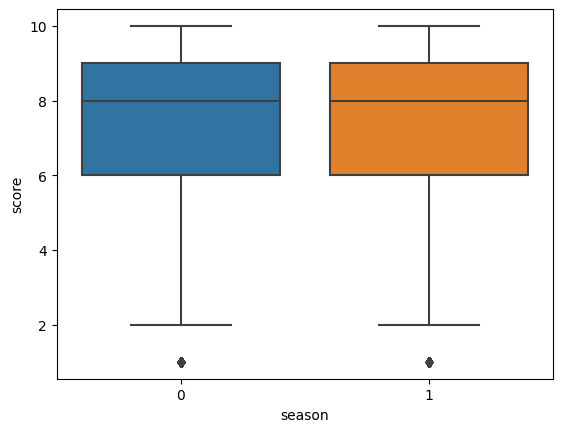

In [13]:
# season ごとに score の分布を可視化
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(x='season', y='score', data=train_data_merged)
plt.show()


In [14]:
# seasonが1の各作品ごとに score の平均を取って、作品名と平均値を表示し、ファイルに出力
season1_mean_score = train_data_merged.loc[train_data_merged['season'] == 1, :].groupby('title')['score'].mean()
season1_mean_score.to_csv('season1_mean_score.csv')

# それなりに関係ないかも

In [15]:
# train_data(user) と profile_data(user) を結合
train_data_merged = pd.merge(train_data_merged, profile_data, left_on='user', right_on='user', how='left')
test_data_merged = pd.merge(test_data_merged, profile_data, left_on='user', right_on='user', how='left')

# train_data_merged の内容を確認
train_data_merged.head()

,user,anime_id,text,score,id,title,synopsis,genre,episodes,members,...,genre_Comedy,genre_Yaoi,genre_Mystery,genre_Psychological,genre_Shounen,genre_Parody,genre_Martial Arts,genre_Yuri,gender,age
0,cd931c240b,6574,\n \n \n \n ...,9,6574,Hanamaru Youchien,"Anzu goes to a kindergarten with her friends, ...","[Slice of Life, Comedy, Seinen]",12.0,57231,...,1,0,0,0,0,0,0,0,Male,36.0
1,bf666ac921,12531,\n \n \n \n ...,8,12531,Sakamichi no Apollon,Introverted classical pianist and top student ...,"[Drama, Josei, Music, Romance, School]",12.0,235523,...,0,0,0,0,0,0,0,0,Unknown,30.0
2,24a73e9958,23079,\n \n \n \n ...,5,23079,Glasslip,What if you hold the power to hear the voices ...,"[Romance, Slice of Life, Supernatural]",13.0,130085,...,0,0,0,0,0,0,0,0,Male,29.0
3,d45057b3ec,8769,\n \n \n \n ...,7,8769,Ore no Imouto ga Konnani Kawaii Wake ga Nai,Kirino Kousaka embodies the ideal student with...,"[Slice of Life, Comedy]",12.0,487655,...,1,0,0,0,0,0,0,0,Male,30.0
4,9b33e2839e,12367,\n \n \n \n ...,2,12367,Shining Hearts: Shiawase no Pan,"One day, a mysterious girl named Kaguya was wa...","[Action, Fantasy]",12.0,35044,...,0,0,0,0,0,0,0,0,Male,28.0


In [16]:
# train_data_merged のカラムを確認
train_data_merged.columns

Index(['user', 'anime_id', 'text', 'score', 'id', 'title', 'synopsis', 'genre',
       'episodes', 'members', 'popularity', 'ranked', 'start_year',
       'member_popularity', 'season', 'genre_Game', 'genre_Slice of Life',
       'genre_Magic', 'genre_Seinen', 'genre_Sci-Fi', 'genre_Harem',
       'genre_Ecchi', 'genre_Sports', 'genre_Thriller', 'genre_Historical',
       'genre_Space', 'genre_Horror', 'genre_Dementia', 'genre_Shounen Ai',
       'genre_Hentai', 'genre_Action', 'genre_Super Power', 'genre_Mecha',
       'genre_Shoujo Ai', 'genre_School', 'genre_Military', 'genre_Kids',
       'genre_Cars', 'genre_Fantasy', 'genre_Demons', 'genre_Josei',
       'genre_Adventure', 'genre_Romance', 'genre_Supernatural',
       'genre_Vampire', 'genre_Drama', 'genre_Police', 'genre_Samurai',
       'genre_Music', 'genre_Shoujo', 'genre_Comedy', 'genre_Yaoi',
       'genre_Mystery', 'genre_Psychological', 'genre_Shounen', 'genre_Parody',
       'genre_Martial Arts', 'genre_Yuri', 'gender', 

In [17]:
# その行以外のuserがつけたscoreの数をカウントして、その値をカラムにする userscore_1 ~ userscore_10
# 先にmapを作る
from collections import defaultdict

user_score_map = defaultdict(lambda: defaultdict(int))
for row in train_data_merged.itertuples():
    user_score_map[row.user][row.score] += 1

# mapを使ってカラムを作る
for i in range(1, 11):
    train_data_merged['userscore_' + str(i)] = train_data_merged.apply(lambda x: user_score_map[x['user']][i] if i != x['score'] else user_score_map[x['user']][i] - 1, axis=1)
    test_data_merged['userscore_' + str(i)] = test_data_merged.apply(lambda x: user_score_map[x['user']][i], axis=1)

In [18]:
# # その行以外のuser がつけた score の平均値を取って、userscore という名前のカラムに追加
# train_data_merged['userscore'] = train_data_merged.groupby('user')['score'].transform(lambda x: (x.sum() - x) / (x.count() - 1) if x.count() > 1 else None)
# test_data_merged['userscore'] = train_data_merged.groupby('user')['score'].transform(lambda x: x.mean() if x.count() > 0 else None)

# # anime ごとに score の平均値を取って、animescore という名前のカラムに追加
# train_data_merged['animescore'] = train_data_merged.groupby('anime_id')['score'].transform(lambda x: x.mean())
# test_data_merged['animescore'] = train_data_merged.groupby('anime_id')['score'].transform(lambda x: x.mean())

# # userscoreの欠損値を、animescoreと全scoreの平均のの相乗平均で埋める
# av_score = train_data_merged['score'].mean()
# train_data_merged['userscore'].fillna((train_data_merged['animescore'] * av_score) ** 0.5, inplace=True)
# test_data_merged['userscore'].fillna((test_data_merged['animescore'] * av_score) ** 0.5, inplace=True)

In [19]:
# text_len を追加
train_data_merged['text_len'] = train_data_merged['text'].apply(lambda x: len(x.replace(' ', '')))

# userごとの平均 text_len を追加
train_data_merged['user_text_len'] = train_data_merged.groupby('user')['text_len'].transform(lambda x: x.mean())
test_data_merged['user_text_len'] = train_data_merged.groupby('user')['text_len'].transform(lambda x: x.mean())


In [20]:
from sklearn.preprocessing import OneHotEncoder

# gender の Non-Binary を Unknown にする
train_data_merged = train_data_merged.replace('Non-Binary', 'Unknown')
test_data_merged = test_data_merged.replace('Non-Binary', 'Unknown')

# genderをOne-Hotエンコーディング
gender_encoder = OneHotEncoder()
gender_one_hot = gender_encoder.fit_transform(train_data_merged[['gender']]).toarray()  # type: ignore
gender_labels = gender_encoder.get_feature_names_out(['gender'])
for i, label in enumerate(gender_labels):
    train_data_merged[label] = gender_one_hot[:, i]

gender_one_hot_test = gender_encoder.transform(test_data_merged[['gender']]).toarray()  # type: ignore
test_data_merged = test_data_merged.drop(columns=['gender'])
for i, label in enumerate(gender_labels):
    test_data_merged[label] = gender_one_hot_test[:, i]


In [21]:
# ['episodes', 'members', 'ranked', 'start_year', 'season', 'genre_*', 'gender', 'age'] カラムを特徴量として摘出する
correct_features = ['episodes', 'members', 'ranked', 'start_year', 'season', 'age', 'user_text_len']
# correct_features.extend([col for col in train_data_merged.columns if col.startswith('genre_')])
# correct_features.extend([col for col in train_data_merged.columns if col.startswith('gender_')])
correct_features.extend([col for col in train_data_merged.columns if col.startswith('userscore_')])
x_train = train_data_merged[correct_features]

x_test = test_data_merged[correct_features]

# score を正解データとして摘出する
y_train = train_data_merged['score']

x_train.columns

Index(['episodes', 'members', 'ranked', 'start_year', 'season', 'age',
       'user_text_len', 'userscore_1', 'userscore_2', 'userscore_3',
       'userscore_4', 'userscore_5', 'userscore_6', 'userscore_7',
       'userscore_8', 'userscore_9', 'userscore_10'],
      dtype='object')

前処理をしてみる

In [ ]:
from sklearn.preprocessing import StandardScaler

# 数値特徴のみを選択
numerical_features = ['episodes', 'members', 'ranked', 'start_year', 'age', 'user_text_len']
scaler = StandardScaler()
x_train[numerical_features] = scaler.fit_transform(x_train[numerical_features])
x_test[numerical_features] = scaler.fit_transform(x_test[numerical_features])

# score_1 ~ score_10 カラムを 行ごとに正規化
columns_to_normalize = [f'userscore_{i}' for i in range(1, 11)]
x_train[columns_to_normalize] = x_train[columns_to_normalize].apply(lambda x: x / x.sum() if x.sum() != 0 else x, axis=1)
x_test[columns_to_normalize] = x_test[columns_to_normalize].apply(lambda x: x / x.sum() if x.sum() != 0 else x, axis=1)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import pytorch_lightning as pl
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

# データの準備
train_data, val_data, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)
train_tensor = TensorDataset(torch.tensor(train_data.values, dtype=torch.float32), torch.tensor(y_train.values, dtype=torch.float32))
val_tensor = TensorDataset(torch.tensor(val_data.values, dtype=torch.float32), torch.tensor(y_val.values, dtype=torch.float32))
train_loader = DataLoader(train_tensor, batch_size=32)
val_loader = DataLoader(val_tensor, batch_size=32)

class ScorePredictor(pl.LightningModule):
    def __init__(self, input_dim):
        super(ScorePredictor, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.BatchNorm1d(64), # バッチ正規化
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.BatchNorm1d(32), # バッチ正規化
            nn.ReLU(),
            nn.Linear(32, 1)
        )
        self.validation_step_outputs = []

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x).squeeze()
        loss = nn.MSELoss()(y_pred, y)
        return {'loss': loss}

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x).squeeze()
        loss = nn.MSELoss()(y_pred, y)
        pred = {'val_loss': loss}
        self.validation_step_outputs.append(pred)
        return pred

    def on_validation_epoch_end(self):
        avg_loss = torch.stack([x['val_loss'] for x in self.validation_step_outputs]).mean()
        self.log('val_loss', avg_loss)
        self.validation_step_outputs = []

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.001)

# 早期停止コールバックの定義
early_stop_callback = EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=True,
    mode='min'
)

# トレーナーの定義
model = ScorePredictor(input_dim=len(correct_features))
trainer = pl.Trainer(max_epochs=100, callbacks=[early_stop_callback])

# 訓練
trainer.fit(model, train_loader, val_loader)

# 検証データでの評価
val_predictions = model(torch.tensor(val_data.values, dtype=torch.float32)).squeeze()
mae = mean_absolute_error(val_predictions.detach().numpy(), y_val.values)
print(f"Mean Absolute Error on Validation Data: {mae}")


best score 4.005  
Mean Absolute Error on Validation Data: 1.5301837173976998  
score 3.49

best score 3.955  
Mean Absolute Error on Validation Data: 1.5341533639389133  
score 3.58

In [ ]:
# x_testをテンソルに変換
x_test_tensor = torch.tensor(x_test.values, dtype=torch.float32)

# モデルを評価モードに設定
model.eval()

# テストデータをモデルに渡して予測を実行
with torch.no_grad():
    predictions = model(x_test_tensor)

# predictionsをnumpy配列に変換
predicted_scores = predictions.numpy()


In [ ]:
# sample_submission.csv を読み込む
sample_submission = pd.read_csv('sample_submission.csv')

# predicted_scores を sample_submission の score に代入
sample_submission['score'] = predicted_scores


In [ ]:
# sample_submission のスコア分布を確認
sample_submission['score'].hist(bins=100)

In [ ]:
# sample_submission のスコアで10より大きいものを10にする
sample_submission.loc[sample_submission['score'] > 10, 'score'] = 10

# sample_submission を出力
sample_submission.to_csv('submission.csv', index=False)